# Adult

In [15]:
import pandas as pd

file_name = "https://raw.githubusercontent.com/neowalter/DA-tour/master/charpter5/adult.data"
adult = pd.read_csv(file_name, header=None, names=["Age", "Work-Class", "fnlwgt", 
                     "Education", "Education-Num", "Marital-Status", "Occupation",
                     "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss",
                     "Hours-per-week", "Native-Country", "Earnings-Raw"])
adult.dropna(how='all', inplace=True)
adult.columns

Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')

In [16]:
adult["Hours-per-week"].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours-per-week, dtype: float64

In [17]:
adult["Work-Class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

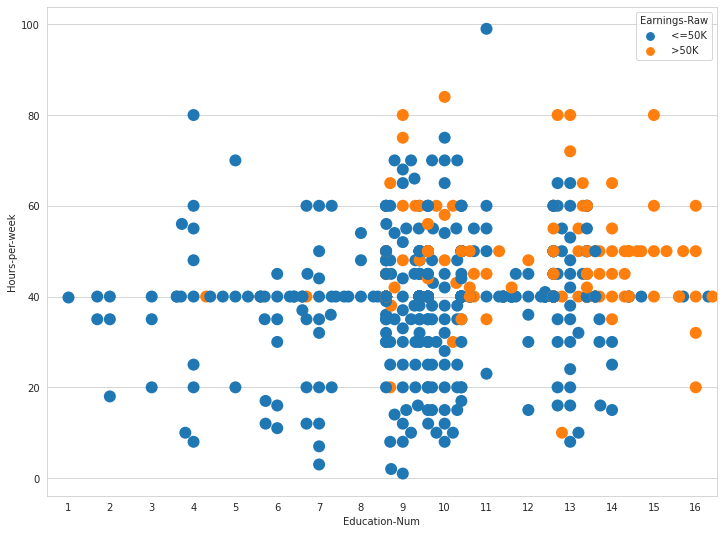

In [18]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 9))
sns.swarmplot(x="Education-Num", y="Hours-per-week", hue="Earnings-Raw", data=adult[::50], size=12)

In [19]:
X = adult[["Age", "Education-Num", "Capital-gain", "Capital-loss", "Hours-per-week"]].values
y = (adult["Earnings-Raw"] == ' >50K').values

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
transformer = SelectKBest(score_func=chi2, k=3)

Xt_chi2 = transformer.fit_transform(X, y)
print(transformer.scores_)

[    8600.61182     2401.42178 82192467.14154  1372145.8902
     6476.409  ]


In [20]:
import numpy as np
from scipy.stats import pearsonr

def multivariate_pearsonr(X, y):
    scores, pvalues = [], []
    for column in range(X.shape[1]):
        cur_score, cur_p = pearsonr(X[:,column], y)
        scores.append(abs(cur_score))
        pvalues.append(cur_p)
    return (np.array(scores), np.array(pvalues))

transformer = SelectKBest(score_func=multivariate_pearsonr, k=3)
Xt_pearson = transformer.fit_transform(X, y)
print(transformer.scores_)

[0.23404 0.33515 0.22333 0.15053 0.22969]


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
scores_chi2 = cross_val_score(clf, Xt_chi2, y, scoring='accuracy')
scores_pearson = cross_val_score(clf, Xt_pearson, y, scoring='accuracy')

print("Chi2 performance: {0:.3f}".format(scores_chi2.mean()))
print("Pearson performance: {0:.3f}".format(scores_pearson.mean()))

Chi2 performance: 0.829
Pearson performance: 0.772


transformer

In [22]:
from sklearn.base import TransformerMixin
from sklearn.utils import as_float_array

class MeanDiscrete(TransformerMixin):
    def fit(self, X, y=None):
        X = as_float_array(X)
        self.mean = np.mean(X, axis=0)
        return self

    def transform(self, X):
        X = as_float_array(X)
        assert X.shape[1] == self.mean.shape[0]
        return X > self.mean

mean_discrete = MeanDiscrete()
X_mean = mean_discrete.fit_transform(X)

Unit test

In [23]:
import numpy as np
from numpy.testing import assert_array_equal

def test_meandiscrete():
    X_test = np.array([[ 0,  2],
                        [ 3,  5],
                        [ 6,  8],
                        [ 9, 11],
                        [12, 14],
                        [15, 17],
                        [18, 20],
                        [21, 23],
                        [24, 26],
                        [27, 29]])
    mean_discrete = MeanDiscrete()
    mean_discrete.fit(X_test)
    assert_array_equal(mean_discrete.mean, np.array([13.5, 15.5]))
    X_transformed = mean_discrete.transform(X_test)
    X_expected = np.array([[ 0,  0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1]])
    assert_array_equal(X_transformed, X_expected)


test_meandiscrete()

Final result

In [24]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('mean_discrete', MeanDiscrete()),
                     ('classifier', DecisionTreeClassifier(random_state=14))])
scores_mean_discrete = cross_val_score(pipeline, X, y, scoring='accuracy')

print("Mean Discrete performance: {0:.5f}".format(scores_mean_discrete.mean()))

Mean Discrete performance: 0.80271


# Ad

In [10]:
import numpy as np
import pandas as pd

def convert_number(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

converters = {}
for i in range(1558):
    converters[i] = convert_number


converters[1558] = lambda x: 1 if x.strip() == "ad." else 0

data_filename = "https://raw.githubusercontent.com/neowalter/DA-tour/master/charpter5/ad.data"
ads = pd.read_csv(data_filename, header=None, converters=converters)
ads.dropna(inplace=True)

X = ads.drop(1558, axis=1).values
y = ads[1558]

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Xd = pca.fit_transform(X)

np.set_printoptions(precision=5, suppress=True)
pca.explained_variance_ratio_

array([0.85363, 0.14473, 0.00103, 0.00006, 0.00003])

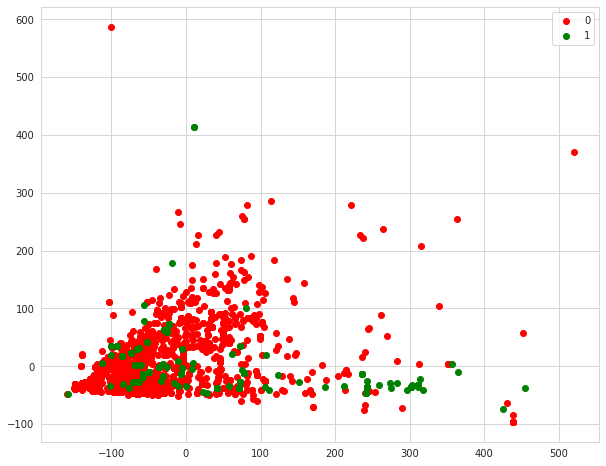

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

classes = set(y)
colors = ['red', 'green']

import seaborn as sns

plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
for cur_class, color in zip(classes, colors):
    mask = (y == cur_class).values
    plt.scatter(Xd[mask,0], Xd[mask,1], marker='o', color=color, label=int(cur_class))
plt.legend()
plt.show()